In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import os
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [27]:
data_in_can_normal = pd.read_csv("data_in_can_normal.csv")
data_in_can_normal.fillna(-1, inplace=True)
data_in_can_fuzz = pd.read_csv("data_in_can_fuzz.csv")
data_in_can_fuzz.fillna(-1, inplace=True)
data_in_can_rep = pd.read_csv("data_in_can_rep.csv")
data_in_can_rep.fillna(-1, inplace=True)

In [28]:
data_in_can_combined = pd.concat([data_in_can_normal, data_in_can_fuzz, data_in_can_rep], ignore_index=True)
data_in_can_combined

,Time_Offset,Type,CAN_ID,Data_Length,One,Two,Three,Four,Five,Six,Seven,Eight,Time_Gap,Label
0,7.5,Rx,0350,8,00,2C,84,FF,FF,00,00,A8,-1.0,0
1,10.1,Rx,04F0,8,00,00,BC,00,00,C8,14,00,2.6,0
2,12.8,Rx,043F,8,0F,47,60,FF,55,00,00,00,2.7,0
3,15.6,Rx,0510,8,00,00,00,00,04,12,00,00,2.8,0
4,19.3,Rx,04F2,8,00,00,9E,38,00,00,00,DF,3.7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558495,600571.9,Rx,04F2,8,00,00,2E,38,00,00,00,8E,2.0,0
558496,600573.1,Rx,0120,4,00,00,00,00,-1,-1,-1,-1,1.2,0
558497,600573.4,Rx,0517,8,00,00,00,00,00,00,00,00,0.3,0
558498,600581.2,Rx,04F0,8,00,00,1C,00,00,C8,14,00,7.8,0


In [29]:
# Identify mixed-type columns
mixed_columns = []
for col in data_in_can_combined.columns:
    unique_types = data_in_can_combined[col].apply(type).unique()
    if len(unique_types) > 1:
        mixed_columns.append(col)

# Convert mixed columns to strings before encoding
for col in mixed_columns:
    data_in_can_combined[col] = data_in_can_combined[col].astype(str)

# Apply Label Encoding to categorical columns
label_encoder = LabelEncoder()
categorical_columns = data_in_can_combined.select_dtypes(include=['object']).columns

for col in categorical_columns:
    data_in_can_combined[col] = label_encoder.fit_transform(data_in_can_combined[col])

# Apply MinMax Scaling to numerical columns
scaler = MinMaxScaler()
numerical_columns = data_in_can_combined.select_dtypes(include=['float64', 'int64']).columns
data_in_can_combined[numerical_columns] = scaler.fit_transform(data_in_can_combined[numerical_columns])

In [30]:
pd.value_counts(data_in_can_combined["Label"])

/tmp/ipykernel_2079167/3134956381.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(data_in_can_combined["Label"])


Label
0.0    552634
0.5      4089
1.0      1777
Name: count, dtype: int64

In [31]:
data_in_can_combined = data_in_can_combined[["CAN_ID", "One", "Two", "Three", "Four", "Five","Six", "Seven", "Eight", "Time_Gap", "Label"]]
#data_in_can_combined = np.array(data_in_can_combined)
data_in_can_combined

,CAN_ID,One,Two,Three,Four,Five,Six,Seven,Eight,Time_Gap,Label
0,0.5000,0.0,0.4,0.530303,1.0,1.000000,0.111111,0.0625,0.374101,0.000000,0.0
1,0.6250,0.0,0.0,0.742424,0.0,0.142857,0.888889,0.3750,0.007194,0.283465,0.0
2,0.5625,0.5,0.6,0.393939,1.0,0.714286,0.111111,0.0625,0.007194,0.291339,0.0
3,0.8125,0.0,0.0,0.000000,0.0,0.285714,0.444444,0.0625,0.007194,0.299213,0.0
4,0.7500,0.0,0.0,0.628788,0.5,0.142857,0.111111,0.0625,0.769784,0.370079,0.0
...,...,...,...,...,...,...,...,...,...,...,...
558495,0.7500,0.0,0.0,0.196970,0.5,0.142857,0.111111,0.0625,0.187050,0.236220,0.0
558496,0.4375,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.173228,0.0
558497,0.8750,0.0,0.0,0.000000,0.0,0.142857,0.111111,0.0625,0.007194,0.102362,0.0
558498,0.6250,0.0,0.0,0.128788,0.0,0.142857,0.888889,0.3750,0.007194,0.692913,0.0


In [32]:
len(data_in_can_combined)

558500

In [33]:
def chunk_time(df, gap):
    X = []
    y = []

    for i in range(0, len(df), gap):
        chunk = df.iloc[i:i + gap]  # Extract the chunk of size 'gap'
        
        # Extract feature values (excluding labels if needed)
        X.append(chunk.drop(columns=['Label']).values if 'Label' in df.columns else chunk.values)
        
        # Extract labels (assuming there's a 'Label' column in df)
        if 'Label' in df.columns:
            if sum(chunk['Label'].values) != 0:  # Fixing the 'sun' typo to 'sum'
                y.append(1)
            else:
                y.append(0)  # Fixing syntax error by adding ':' after 'else'

    return X, y

In [34]:
X_, y_ = chunk_time(data_in_can_combined, 10)

In [35]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def split_data(X, y, test_size_per_class=500, val_size_per_class=50, random_state=42):
    """
    Splits the dataset into training, validation, and test sets while ensuring a balanced split.

    Parameters:
    - X: List or NumPy array of feature data.
    - y: List or NumPy array of labels.
    - test_size_per_class: Number of samples per class for the test set.
    - val_size_per_class: Number of samples per class for the validation set.
    - random_state: Random seed for reproducibility.

    Returns:
    - X_train, y_train: Training set.
    - X_val, y_val: Validation set.
    - X_test, y_test: Test set.
    """
    # Convert to NumPy array
    X = np.array(X)
    y = np.array(y)

    # Separate data into classes
    X_class_0, X_class_1 = X[y == 0], X[y == 1]
    y_class_0, y_class_1 = y[y == 0], y[y == 1]

    # Ensure we do not request more samples than available
    test_size_0 = min(test_size_per_class, len(y_class_0))
    test_size_1 = min(test_size_per_class, len(y_class_1))

    # Split test set (500 from class 0, 500 from class 1)
    X_test_0, X_remain_0, y_test_0, y_remain_0 = train_test_split(
        X_class_0, y_class_0, test_size=(len(y_class_0) - test_size_0), random_state=random_state
    )
    X_test_1, X_remain_1, y_test_1, y_remain_1 = train_test_split(
        X_class_1, y_class_1, test_size=(len(y_class_1) - test_size_1), random_state=random_state
    )

    # Ensure we do not request more samples than available
    val_size_0 = min(val_size_per_class, len(y_remain_0))
    val_size_1 = min(val_size_per_class, len(y_remain_1))

    # Split validation set (50 from class 0, 50 from class 1)
    X_val_0, X_train_0, y_val_0, y_train_0 = train_test_split(
        X_remain_0, y_remain_0, test_size=(len(y_remain_0) - val_size_0), random_state=random_state
    )
    X_val_1, X_train_1, y_val_1, y_train_1 = train_test_split(
        X_remain_1, y_remain_1, test_size=(len(y_remain_1) - val_size_1), random_state=random_state
    )

    # Concatenate the sets
    X_train, y_train = np.concatenate([X_train_0, X_train_1]), np.concatenate([y_train_0, y_train_1])
    X_test, y_test = np.concatenate([X_test_0, X_test_1]), np.concatenate([y_test_0, y_test_1])
    X_val, y_val = np.concatenate([X_val_0, X_val_1]), np.concatenate([y_val_0, y_val_1])

    # Shuffle to ensure randomness
    X_train, y_train = shuffle(X_train, y_train, random_state=random_state)
    X_test, y_test = shuffle(X_test, y_test, random_state=random_state)
    X_val, y_val = shuffle(X_val, y_val, random_state=random_state)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [36]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X_, y_)

# Check dataset sizes
print("Training set:", len(X_train), len(y_train))
print("Validation set:", len(X_val), len(y_val))  # Expected: 100
print("Test set:", len(X_test), len(y_test))      # Expected: 1000

Training set: 54750 54750
Validation set: 100 100
Test set: 1000 1000


In [37]:
print(X_train[0])
print("\n")
print(y_train[0])
print("\n")
print(X_train[0].shape)
print(y_train[0].shape)

[[0.625      0.         0.         0.49242424 0.         0.14285714
  0.88888889 0.375      0.00719424 0.8503937 ]
 [0.6875     0.83333333 1.         0.01515152 0.         0.14285714
  0.11111111 0.0625     0.00719424 0.1023622 ]
 [1.         0.16666667 0.         0.         0.33333333 0.85714286
  1.         0.625      0.02158273 0.1023622 ]
 [0.5625     0.5        0.6        0.39393939 1.         0.71428571
  0.11111111 0.0625     0.00719424 0.11023622]
 [0.375      1.         0.4        0.14393939 0.16666667 0.14285714
  0.11111111 0.0625     0.00719424 0.17322835]
 [0.5        0.         0.4        0.89393939 1.         1.
  0.11111111 0.0625     0.60431655 0.49606299]
 [0.75       0.         0.         0.62878788 0.5        0.14285714
  0.11111111 0.0625     0.5323741  0.28346457]
 [0.5625     0.5        0.6        0.39393939 1.         0.71428571
  0.11111111 0.0625     0.00719424 0.22047244]
 [0.3125     0.         0.8        0.         0.         0.
  0.         0.         0.  

In [38]:
# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [39]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Make it (batch_size, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [40]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

# Define GRU Model
class GRUBinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
        super(GRUBinaryClassifier, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, h_n = self.gru(x)  # We use the last hidden state
        out = self.fc(h_n[-1])  # Take the last layer's hidden state
        return self.sigmoid(out)

In [ ]:
# Initialize Model
input_size = X_train.shape[2]  # Number of features
model = GRUBinaryClassifier(input_size).to("cuda" if torch.cuda.is_available() else "cpu")

# Loss and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [42]:
# Early Stopping Implementation
class EarlyStopping:
    def __init__(self, patience=10, save_path="best_model.pth"):
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.save_path = save_path

    def check_early_stop(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)  # Save the best model
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True  # Stop training
        return False

In [43]:
# Training Loop
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
early_stopper = EarlyStopping(patience=20, save_path="gru_binary_classification.pth")

In [44]:
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation Step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            val_outputs = model(X_val_batch)
            val_loss += criterion(val_outputs, y_val_batch).item()

    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Check early stopping
    if early_stopper.check_early_stop(val_loss, model):
        print("Early stopping triggered.")
        break

Epoch [1/1000], Train Loss: 0.1929, Val Loss: 0.5445
Epoch [2/1000], Train Loss: 0.1046, Val Loss: 0.4477
Epoch [3/1000], Train Loss: 0.0959, Val Loss: 0.5534
Epoch [4/1000], Train Loss: 0.0816, Val Loss: 0.4562
Epoch [5/1000], Train Loss: 0.0699, Val Loss: 0.3268
Epoch [6/1000], Train Loss: 0.0645, Val Loss: 0.3687
Epoch [7/1000], Train Loss: 0.0610, Val Loss: 0.3142
Epoch [8/1000], Train Loss: 0.0577, Val Loss: 0.2665
Epoch [9/1000], Train Loss: 0.0549, Val Loss: 0.3928
Epoch [10/1000], Train Loss: 0.0536, Val Loss: 0.3416
Epoch [11/1000], Train Loss: 0.0529, Val Loss: 0.2871
Epoch [12/1000], Train Loss: 0.0513, Val Loss: 0.3575
Epoch [13/1000], Train Loss: 0.0507, Val Loss: 0.3267
Epoch [14/1000], Train Loss: 0.0487, Val Loss: 0.3101
Epoch [15/1000], Train Loss: 0.0486, Val Loss: 0.2804
Epoch [16/1000], Train Loss: 0.0466, Val Loss: 0.3641
Epoch [17/1000], Train Loss: 0.0448, Val Loss: 0.3343
Epoch [18/1000], Train Loss: 0.0440, Val Loss: 0.3964
Epoch [19/1000], Train Loss: 0.0432, 

In [45]:
# Load the best saved model
model.load_state_dict(torch.load("gru_binary_classification.pth"))

# Evaluate on Test Data
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
        y_pred = model(X_test_batch)
        y_pred = (y_pred >= 0.5).float()  # Convert probabilities to binary predictions
        correct += (y_pred == y_test_batch).sum().item()
        total += y_test_batch.size(0)

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8980


/tmp/ipykernel_2079167/669875935.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("gru_binary_classification.pth"))


Confusion Matrix:
[[497   3]
 [ 99 401]]


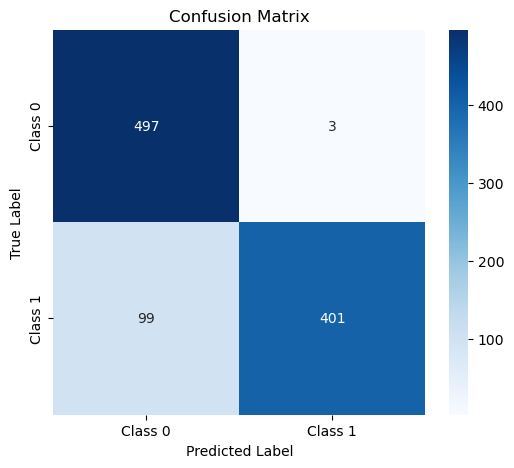

In [46]:
# Ensure model is in evaluation mode
model.eval()

# Store true labels and predictions
y_true = []
y_pred = []

# Loop through test set and collect predictions
with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
        
        outputs = model(X_test_batch)
        predicted = (outputs >= 0.5).float()  # Convert probabilities to binary predictions
        
        y_true.extend(y_test_batch.cpu().numpy().flatten())  # Flatten to 1D array
        y_pred.extend(predicted.cpu().numpy().flatten())  # Flatten to 1D array

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print Confusion Matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [47]:
def plot_confusion_matrix_with_percentages_bin(y_pred, y_test, labels):
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Convert the counts to percentages along columns (category-wise percentages)
    col_sums = cm.sum(axis=1)
    cm_percentages = cm / col_sums[:, np.newaxis] * 100
    
    # Create a heatmap with seaborn
    plt.figure(figsize=(8, 7))

    # Plot the confusion matrix as a heatmap with annotations for both numbers and percentages
    for i in range(len(cm)):
        for j in range(len(cm)):
            # Add actual numbers as text in the center of each cell
            plt.text(j + 0.5, i + 0.5, str(cm[i, j]), ha='center', va='center', fontsize=25, fontweight='bold', color='black')
            # Add percentages as text on top of the actual numbers
            plt.text(j + 0.5, i + 0.65, f'{cm_percentages[i, j]:.2f}%', ha='center', va='center', fontsize=25, fontweight='bold', color='black')

    # Create the heatmap without showing the color bar
    sns.heatmap(cm, annot=False, cmap="Pastel2", cbar=False)

    # Add axis labels and title
    plt.xlabel("Predicted Class", fontweight="bold", fontsize=19, color='darkblue')
    plt.ylabel("Actual Class", fontweight="bold", fontsize=19, color='darkblue')

    # Set custom tick labels for x and y axes
    plt.xticks(np.arange(len(labels)) + 0.5, labels, fontweight="bold", fontsize=16)
    plt.yticks(np.arange(len(labels)) + 0.5, labels, fontweight="bold", fontsize=16)
    
    # Manually set the color for the "Attack Free" label
    x_ticks = plt.gca().get_xticklabels()
    x_ticks[labels.index("Attack Free")].set_color('Green')
    y_ticks = plt.gca().get_yticklabels()
    y_ticks[labels.index("Attack Free")].set_color('Green')
    
    # Manually set the color for the "Attack" label
    x_ticks = plt.gca().get_xticklabels()
    x_ticks[labels.index("Attack")].set_color('Red')
    y_ticks = plt.gca().get_yticklabels()
    y_ticks[labels.index("Attack")].set_color('Red')

    plt.show()

    # Get the classification report
    report = classification_report(y_test, y_pred, target_names=labels)
    
    # Compute AUC
    auc_score = roc_auc_score(y_test, y_pred)
    print(f"\nAUC Score: {auc_score:.2f}")

    print("\nClassification Report:")
    print(report)

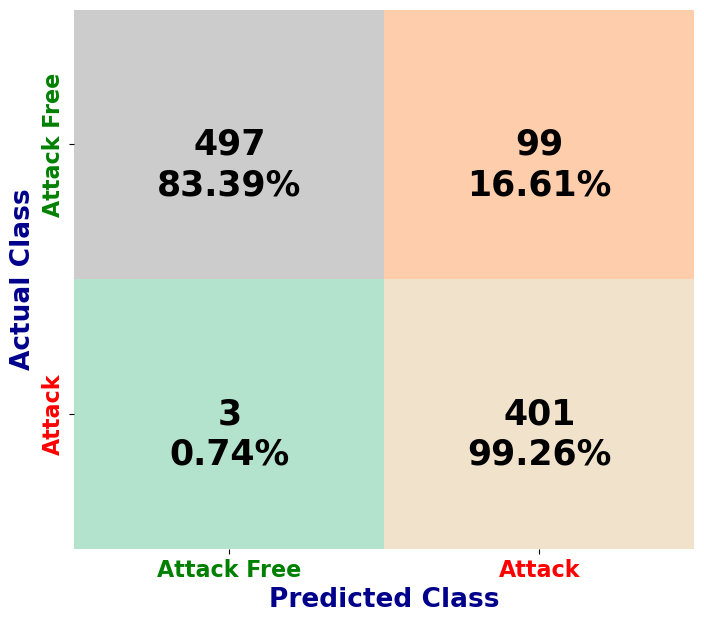


AUC Score: 0.91

Classification Report:
              precision    recall  f1-score   support

 Attack Free       0.99      0.83      0.91       596
      Attack       0.80      0.99      0.89       404

    accuracy                           0.90      1000
   macro avg       0.90      0.91      0.90      1000
weighted avg       0.92      0.90      0.90      1000



In [48]:
plot_confusion_matrix_with_percentages_bin(y_true, y_pred, labels=["Attack Free", "Attack"])

ROC AUC Score: 0.9901


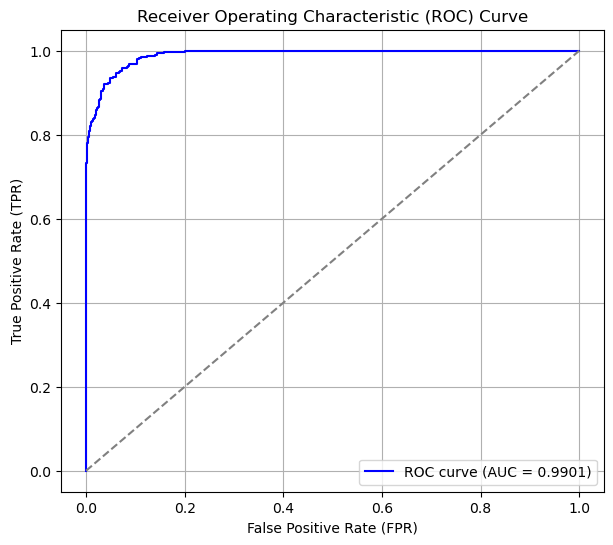

In [49]:
# Ensure model is in evaluation mode
model.eval()

# Store true labels and predicted probabilities
y_true = []
y_probs = []  # Store probabilities instead of binary predictions

# Loop through test set and collect predictions
with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
        
        outputs = model(X_test_batch)  # Get raw probability scores
        y_true.extend(y_test_batch.cpu().numpy().flatten())  # Flatten to 1D array
        y_probs.extend(outputs.cpu().numpy().flatten())  # Flatten to 1D array

# Compute ROC AUC score
roc_auc = roc_auc_score(y_true, y_probs)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, y_probs)

# Plot ROC Curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [50]:
# Ensure model is in evaluation mode
model.eval()

# Store true labels and predictions
y_true = []
y_pred = []

# Loop through test set and collect predictions
with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
        
        outputs = model(X_test_batch)
        predicted = (outputs >= 0.5).float()  # Convert probabilities to binary predictions
        
        y_true.extend(y_test_batch.cpu().numpy().flatten())  # Flatten to 1D array
        y_pred.extend(predicted.cpu().numpy().flatten())  # Flatten to 1D array

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Extract values from the confusion matrix
TN, FP, FN, TP = cm.ravel()

# Compute False Positive Rate (FPR)
FPR = FP / (FP + TN)

# Print classification report
report = classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

# Print False Positive Rate
print(f"False Positive Rate (FPR): {FPR:.4f}")

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.83      0.99      0.91       500
     Class 1       0.99      0.80      0.89       500

    accuracy                           0.90      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000

False Positive Rate (FPR): 0.0060
